In [1]:
import pandas as pd
import numpy as np
import os,sys
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount("/content/drive")
!ls
%cd /content/drive/MyDrive/Healthcare_AI_Assignment_2
!ls

Mounted at /content/drive
drive  sample_data
/content/drive/MyDrive/Healthcare_AI_Assignment_2
'01_116_Healthcare_and_AI_Lab_2__Time_based_prediction (1).pdf'
 Assignment_2-Student_version.ipynb
 HDeviceCGM.csv


In [106]:
#Parameters
window_size=  14 #NOTE LATER WE FIND OUT THAT THE BEST WINDOW_SIZE is 4 for our model
batch_size= 32

# Understanding the data

In [17]:
dataset = pd.read_csv("HDeviceCGM.csv") #READING DATASET
print(dataset.info())
print(dataset.describe())
print(dataset.head())
#THERE ARE NO NULL DATA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962 entries, 0 to 2961
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   RecID                          2962 non-null   int64 
 1   ParentHDeviceUploadsID         2962 non-null   int64 
 2   PtID                           2962 non-null   int64 
 3   SiteID                         2962 non-null   int64 
 4   DeviceDtTmDaysFromEnroll       2962 non-null   int64 
 5   DeviceTm                       2962 non-null   object
 6   DexInternalDtTmDaysFromEnroll  2962 non-null   int64 
 7   DexInternalTm                  2962 non-null   object
 8   RecordType                     2962 non-null   object
 9   GlucoseValue                   2962 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 231.5+ KB
None
              RecID  ...  GlucoseValue
count  2.962000e+03  ...   2962.000000
mean   1.505224e+07  ...    128.020257
std    4.14

In [20]:
dataset.drop(dataset.columns.difference(['RecID','DeviceDtTmDaysFromEnroll','GlucoseValue']), 1, inplace=True) #DROPPING COLUMNS THAT ARE NOT NEEDED FOR MODEL
dataset.head()
print(dataset.shape)

(2962, 3)


Checkpoint1:Study the training data-set and answer the following 
    1) How many sets of continuous training data sets do you have available 
    2) Thecount of samples points per training data sets. Segments the data-sets into training and testing.

In [38]:
print("There are 11 sets of continuous training data")
count_series= dataset.groupby(["DeviceDtTmDaysFromEnroll"]).count()
for i , j in count_series.iterrows():
    print( "Set ", i, " has a count of ", j["RecID"] , " datapoints")


There are 11 sets of continuous training data
Set  0  has a count of  101  datapoints
Set  1  has a count of  292  datapoints
Set  2  has a count of  290  datapoints
Set  3  has a count of  291  datapoints
Set  4  has a count of  294  datapoints
Set  5  has a count of  297  datapoints
Set  6  has a count of  290  datapoints
Set  7  has a count of  231  datapoints
Set  8  has a count of  292  datapoints
Set  9  has a count of  291  datapoints
Set  10  has a count of  293  datapoints


# Data Pre-Processing

In [108]:
#The first step is to split a continuous set into first 'n' train and last 'm' test
#After that we put 'x' training examples into 1 window and create several windows of training and test , where x is the window size
from sklearn.model_selection import train_test_split
def generate_training_data(window_size):
    print("received a window size of " , window_size)
    train_array=[]
    test_array=[]
    train_test_split=0.8
    for i in range(0, 11): #extracting train and test data from continous sets
        instance_count = dataset[dataset["DeviceDtTmDaysFromEnroll"]==i].count()["RecID"]
        train_array.append((dataset[dataset["DeviceDtTmDaysFromEnroll"]==i]["GlucoseValue"]).values[0:int(instance_count*train_test_split//1)])
        test_array.append((dataset[dataset["DeviceDtTmDaysFromEnroll"]==i]["GlucoseValue"]).values[int(instance_count*train_test_split//1):])

    X_train=[]
    Y_train=[]
    X_test=[]
    Y_test=[]
    for i in range(0, len(train_array)): #Creating train and test splits using windows
        for j in range(0, len(train_array[i])-window_size):
            X_train.append(train_array[i][j:j+window_size])
            Y_train.append(train_array[i][j+window_size])
    for i in range(0, len(test_array)):
        for j in range(0, len(test_array[i])-window_size):
            X_test.append(test_array[i][j:j+window_size])
            Y_test.append(test_array[i][j+window_size])
    X_train = np.array(X_train) #reshaping with third dimension =1 to ensure compatibility with lstm
    X_train=X_train.reshape((X_train.shape[0] ,X_train.shape[1] , 1))
    X_test = np.array(X_test)
    X_test=X_test.reshape((X_test.shape[0] ,X_test.shape[1] , 1))
    Y_train = np.array(Y_train)
    Y_train=Y_train.reshape((Y_train.shape[0]  , 1))
    Y_test = np.array(Y_test)
    Y_test=Y_test.reshape((Y_test.shape[0] , 1))
    
    return X_train, Y_train, X_test, Y_test

Checkpoint2:Display the dimensions for your pre-processed data and explain how it the window size is incorporated into this structure.

In [128]:
X_train, Y_train, X_test, Y_test = generate_training_data(window_size)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print("The second dimension of our shape in the training data set is the window_size ")
print("So Each input is basically a window of elements , with the size of the window = window_size variable, while the output is 1")
print("TO ANSWER THE SECOND QUESTION IN CHECKPOINT 1, we have " , X_train.shape[0], " training examples and ", X_test.shape[0] , "of testing examples with window size as " , window_size)


received a window size of  14
(2210, 14, 1)
(444, 14, 1)
(2210, 1)
(444, 1)
The second dimension of our shape in the training data set is the window_size 
So Each input is basically a window of elements , with the size of the window = window_size variable, while the output is 1
TO ANSWER THE SECOND QUESTION IN CHECKPOINT 1, we have  2210  training examples and  444 of testing examples with window size as  14


So for example, input 1 would be [[300],[192],[123],[110],[144]] and output 1 would be [231] where input is a window_size x 1 shape and output is 1 but since there are N inputs, the dimension is N x window_size x 1 and output is N x 1

In [ ]:
#CHECKPOINT 3:Explain how this many-to-one structure is presented is incom-perated in your data structure

Our input is a sequence: ie, there is a window of elements which represents the "many" aspect of our model while the output is just 1 element (the next element in the sequence) and represents the "one" aspect of our model. This is incorporated in our model by having an lstm layer, accepting an input shape of (window_size, 1) which refers to the "many" while our output is a dense layer with one output , which refers to the "one". Hence our structure is a many-to-one structure.

# Modelling And training

Checkpoint 4: Select the correct Loss Function and optimiser and explain the reason for your choice

In [114]:
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.models import Sequential
import tensorflow as tf
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1) , activation= "relu"))
model.add(Dense(1, activation='linear'))
model.compile( loss='mae',optimizer='adam', metrics= [tf.keras.metrics.RootMeanSquaredError()])


Our problem is a regression problem and hence we need to output a number that corresponds to the next element in the time series (glucose data). Hence the best way to look for loss is by comparing groudn truth vs prediction. Our loss function is MAE which is mean absolute error (the absolute difference between our prediction and ground truth) while the metric we used to measure was RMSE. MAE is good as it doesnt overly get affected by outliers, converges faster due to having a greater slow towards the minima and is a good metric for regression evaluation.

Adam and SGD were two optimizers I considered.
Adam relies on the theory that learning rate is like a heavy ball and adds natural momentum to the training process, leading to faster convergence. Not only that, Adam also converged faster in our training data as compared to SGD due to the adaptive learning rate.

In [115]:
results = model.fit(X_train, Y_train, validation_split= 0.2, shuffle=True, epochs=100, batch_size=batch_size)

Epoch 1/100
56/56 [==============================] - 4s 25ms/step - loss: 40.1667 - root_mean_squared_error: 54.5840 - val_loss: 18.3447 - val_root_mean_squared_error: 34.7620
Epoch 2/100
56/56 [==============================] - 1s 19ms/step - loss: 12.7351 - root_mean_squared_error: 22.8558 - val_loss: 19.1007 - val_root_mean_squared_error: 35.7273
Epoch 3/100
56/56 [==============================] - 1s 19ms/step - loss: 14.0131 - root_mean_squared_error: 24.5219 - val_loss: 31.9568 - val_root_mean_squared_error: 50.3355
Epoch 4/100
56/56 [==============================] - 1s 22ms/step - loss: 21.7089 - root_mean_squared_error: 34.0420 - val_loss: 17.3969 - val_root_mean_squared_error: 35.3573
Epoch 5/100
56/56 [==============================] - 1s 19ms/step - loss: 13.2108 - root_mean_squared_error: 23.2274 - val_loss: 23.5252 - val_root_mean_squared_error: 37.9791
Epoch 6/100
56/56 [==============================] - 1s 19ms/step - loss: 16.4607 - root_mean_squared_error: 25.3369 - v

Checkpoint 5: Graph and display the training loss of the model.

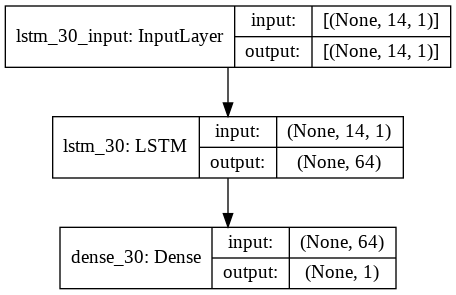

In [116]:
dot_img_file = './model_architecture.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, expand_nested=True,show_shapes=True)

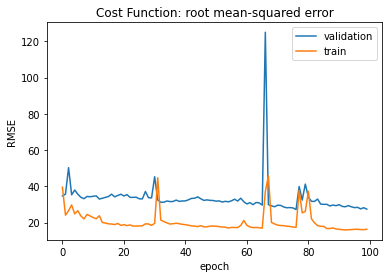

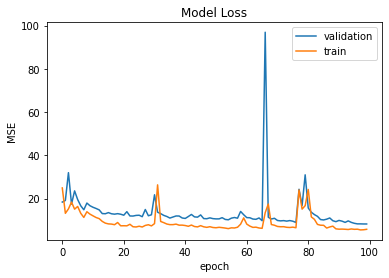

In [117]:
#plotting the training/validation losses
plt.plot(results.history['val_root_mean_squared_error'])
plt.plot(results.history['root_mean_squared_error'])

plt.title('Cost Function: root mean-squared error')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend([ 'validation','train'], loc='upper right')
plt.show()

#mean losses
plt.plot(results.history['val_loss'])
plt.plot(results.history['loss'])

plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend([ 'validation','train'], loc='upper right')
plt.show()

# Validation

Checkpoint 6: Graph the remaining instances and plot them (Provide the
true data and the validated data on the same graph), display the mean loss for
each of the instance.

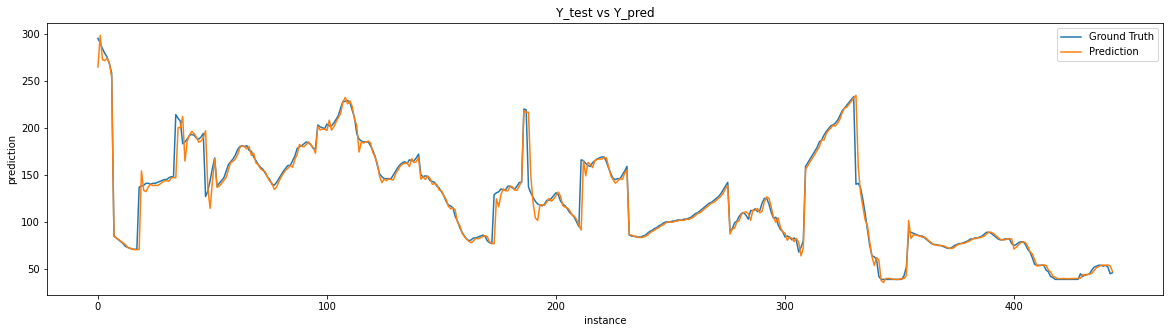

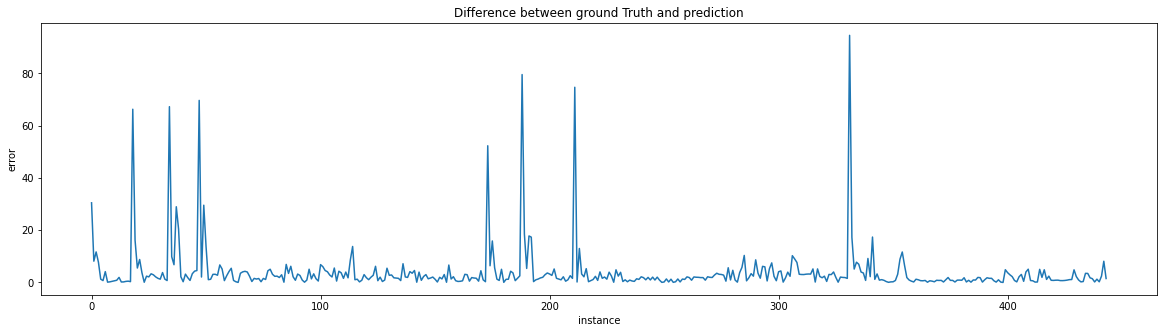

In [118]:
predictions = model.predict(X_test)
#plotting the ground truth vs prediction for each instance
plt.figure(figsize=(20,5))
plt.plot(Y_test)
plt.plot(predictions)
plt.title('Y_test vs Y_pred')
plt.ylabel('prediction')
plt.xlabel('instance')
plt.legend(['Ground Truth', 'Prediction'], loc='upper right')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(abs(predictions-Y_test))
plt.title('Difference between ground Truth and prediction')
plt.ylabel('error')
plt.xlabel('instance')
plt.show()

#HERE ERROR IS THE MEAN LOSS

# Optimisation

Checkpoint 7: Write a short report presenting your analysis on the optimal hyper-parameter of choice. You may include the necessary graphs or printout to explain your optimal hyper-parameter of choice.

There were several hyperparameters to consider. I considered the Batch size, window_size, choice of optimizer, number of epochs, number of hidden units in the LSTM. However for the assignment, we are asked to only tweak the window size and after experimenting, we can conclude that a window_size of 4 is the optimal

In [120]:
result_dictionary={} #dictionary containing training/val loss values of every model
prediction_dictionary={} #dictionary containing the predictions of different models on test data post training
for window_sz in range(3,20): #Trying out different window sizes to find out which works best
    print("TRAINING FOR WINDOW SIZE = ", window_sz)
    X_train, Y_train, X_test, Y_test = generate_training_data(window_sz)
    model = Sequential()
    model.add(LSTM(64, input_shape=(window_sz, 1) , activation= "relu"))
    model.add(Dense(1, activation='linear'))
    model.compile( loss='mae',optimizer='adam', metrics= [tf.keras.metrics.RootMeanSquaredError()])
    results_temp = model.fit(X_train, Y_train, validation_split= 0.2, shuffle=True, epochs=50, batch_size=batch_size)
    result_dictionary["result_"+str(window_sz)] = results_temp
    predictions_temp = model.predict(X_test)
    prediction_dictionary["prediction_"+str(window_sz)] = predictions_temp


TRAINING FOR WINDOW SIZE =  3
received a window size of  3
Epoch 1/50
59/59 [==============================] - 4s 13ms/step - loss: 104.7979 - root_mean_squared_error: 117.0067 - val_loss: 10.2964 - val_root_mean_squared_error: 27.8050
Epoch 2/50
59/59 [==============================] - 0s 7ms/step - loss: 7.2445 - root_mean_squared_error: 18.0087 - val_loss: 7.4910 - val_root_mean_squared_error: 26.5055
Epoch 3/50
59/59 [==============================] - 0s 7ms/step - loss: 5.8676 - root_mean_squared_error: 16.3983 - val_loss: 7.0661 - val_root_mean_squared_error: 26.1645
Epoch 4/50
59/59 [==============================] - 0s 7ms/step - loss: 6.0516 - root_mean_squared_error: 18.7832 - val_loss: 7.1544 - val_root_mean_squared_error: 26.1681
Epoch 5/50
59/59 [==============================] - 0s 6ms/step - loss: 6.4146 - root_mean_squared_error: 18.8808 - val_loss: 8.2604 - val_root_mean_squared_error: 26.6825
Epoch 6/50
59/59 [==============================] - 0s 7ms/step - loss: 6.49

received a window size of  3


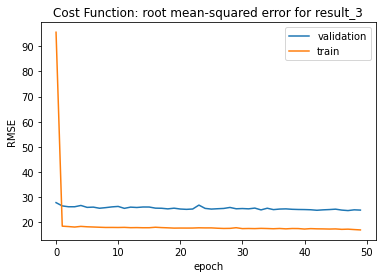

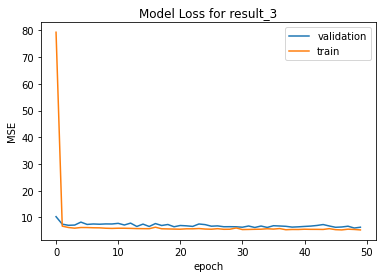

received a window size of  4


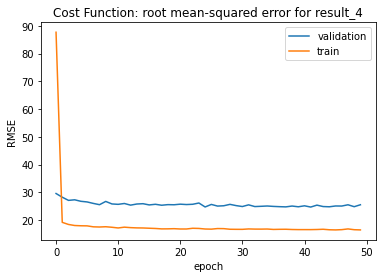

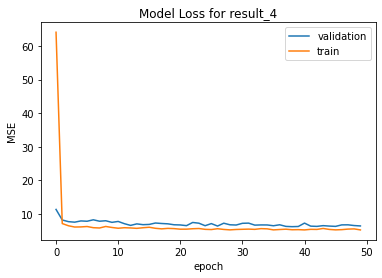

received a window size of  5


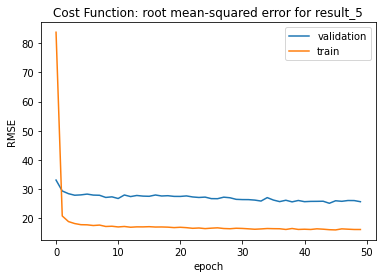

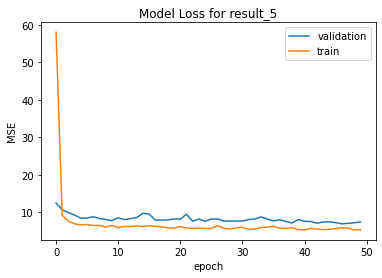

received a window size of  6


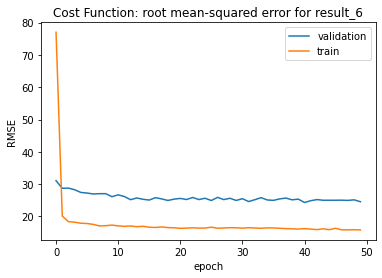

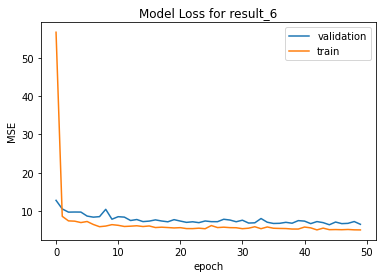

received a window size of  7


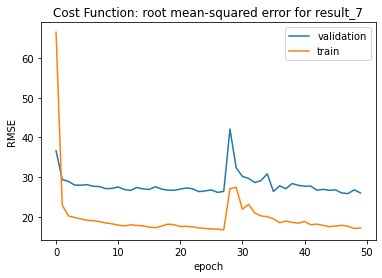

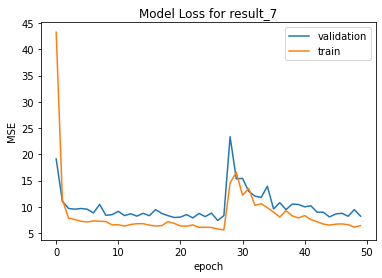

received a window size of  8


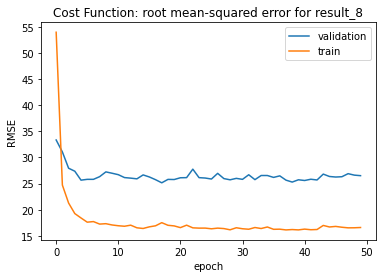

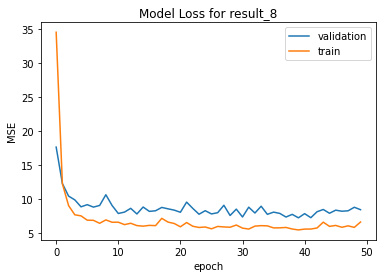

received a window size of  9


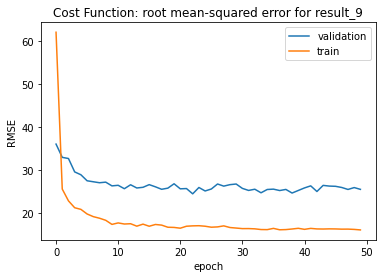

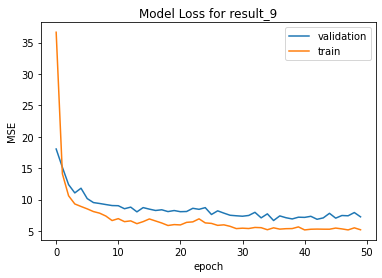

received a window size of  10


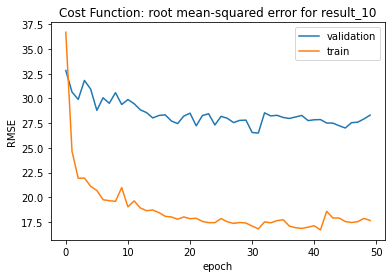

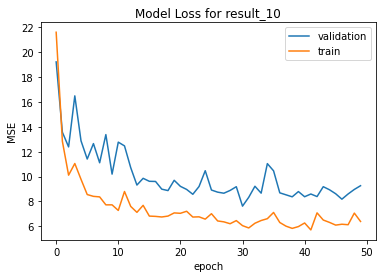

received a window size of  11


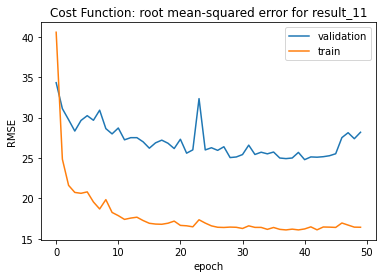

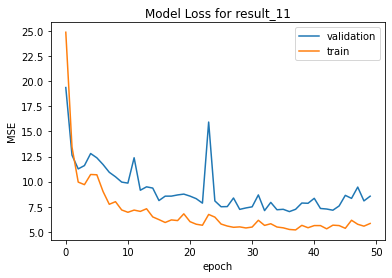

received a window size of  12


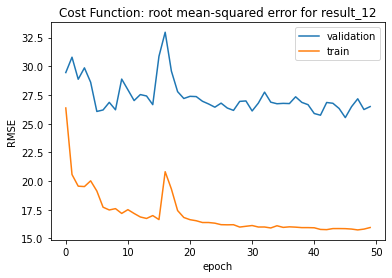

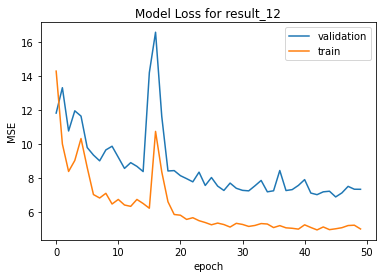

received a window size of  13


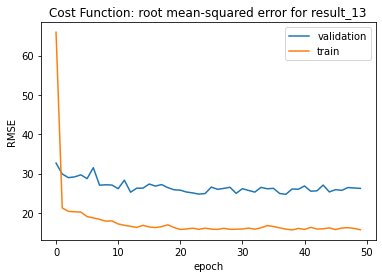

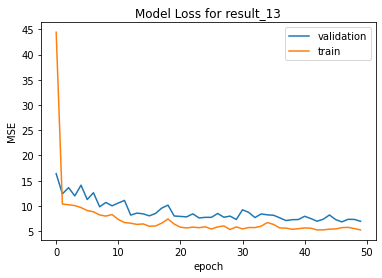

received a window size of  14


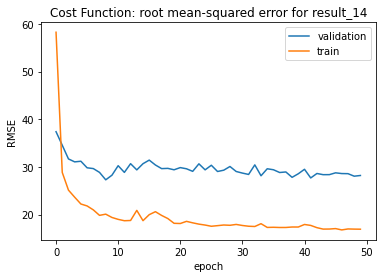

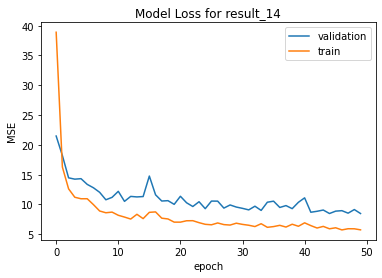

received a window size of  15


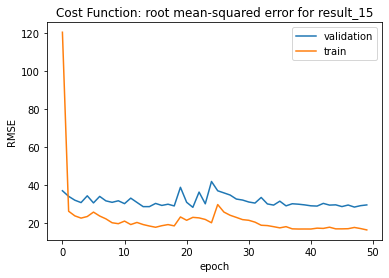

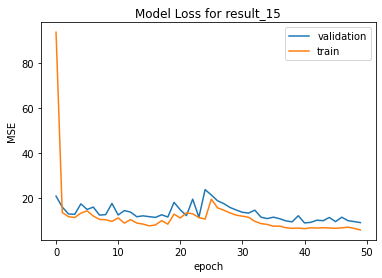

received a window size of  16


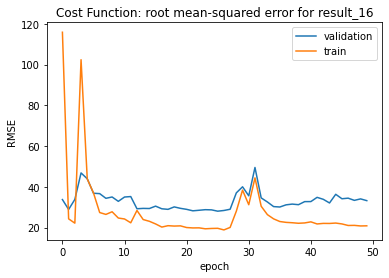

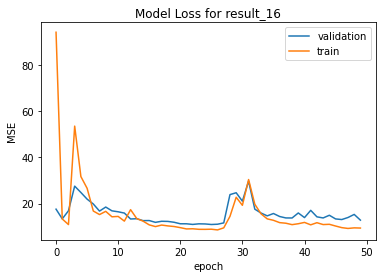

received a window size of  17


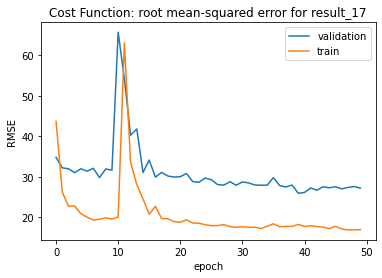

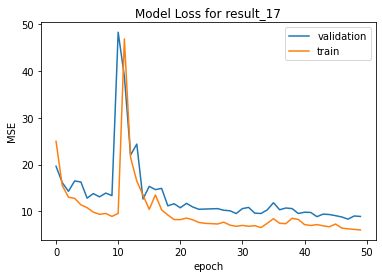

received a window size of  18


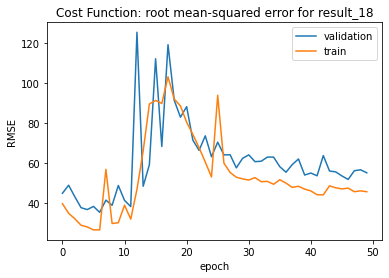

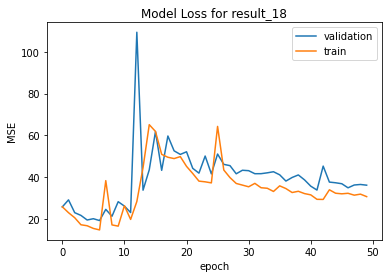

received a window size of  19


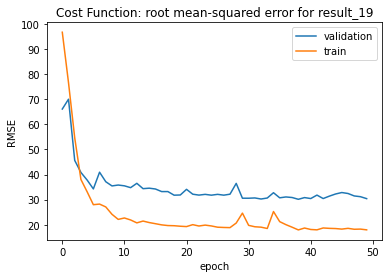

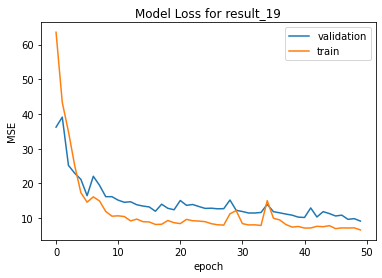

In [121]:
for keys in result_dictionary:
#plotting the training and validation losses
    X_train, Y_train, X_test, Y_test = generate_training_data(int(keys.split("_")[1]))
    plt.plot(result_dictionary[keys].history['val_root_mean_squared_error'])
    plt.plot(result_dictionary[keys].history['root_mean_squared_error'])

    plt.title('Cost Function: root mean-squared error for '+keys)
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend([ 'validation','train'], loc='upper right')
    plt.show()

    # loss
    plt.plot(result_dictionary[keys].history['val_loss'])
    plt.plot(result_dictionary[keys].history['loss'])

    plt.title('Model Loss for '+ keys)
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend([ 'validation','train'], loc='upper right')
    plt.show()


received a window size of  3


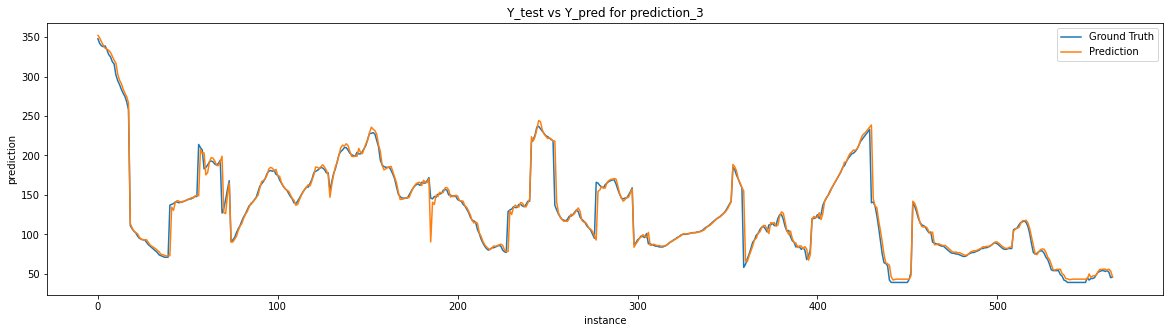

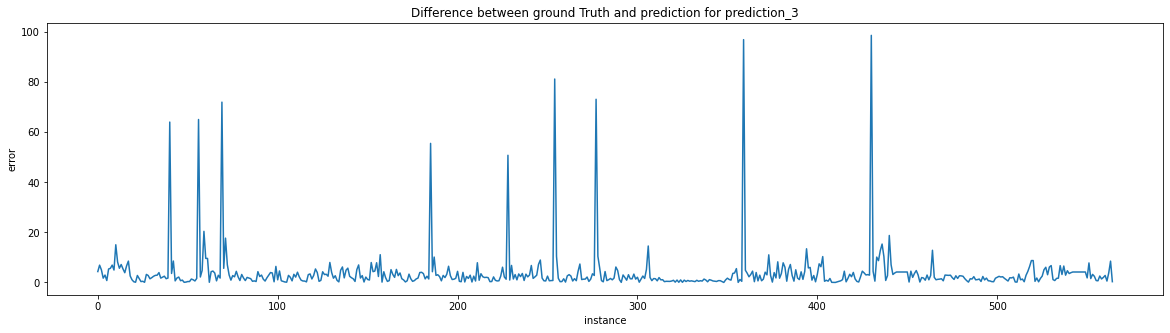

received a window size of  4


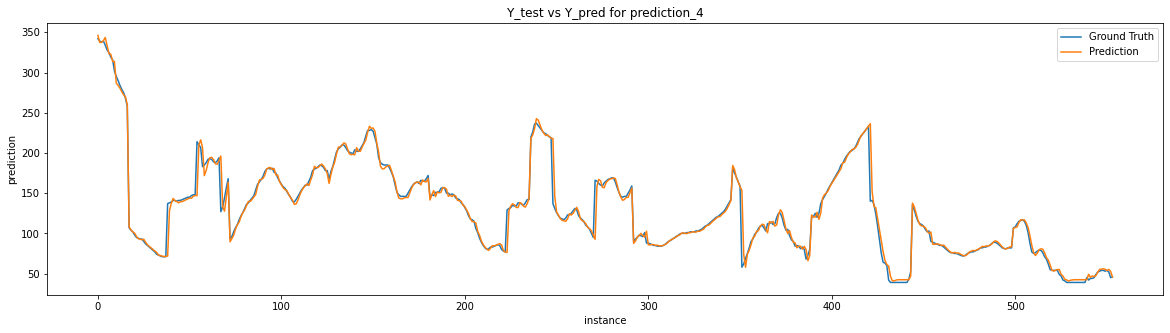

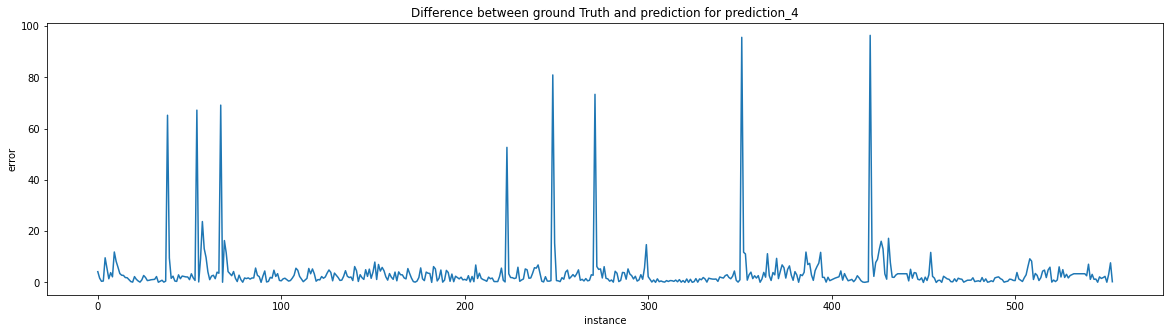

received a window size of  5


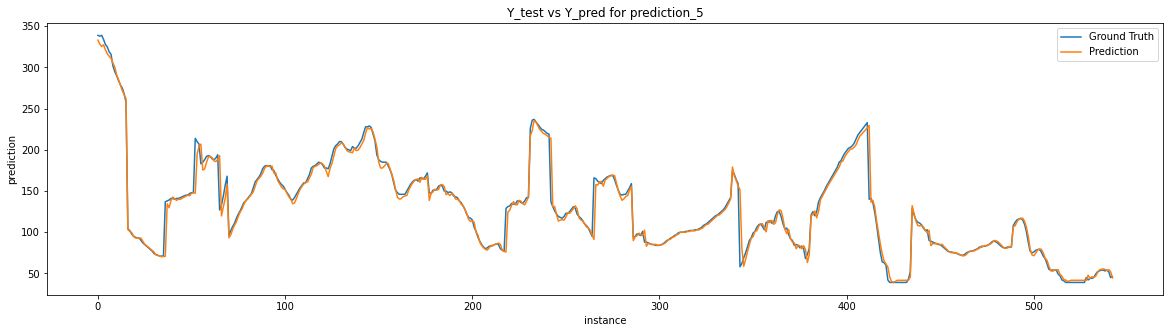

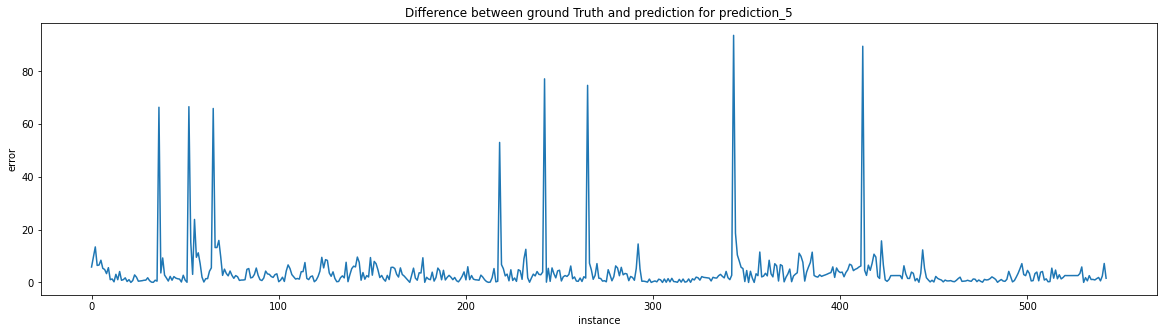

received a window size of  6


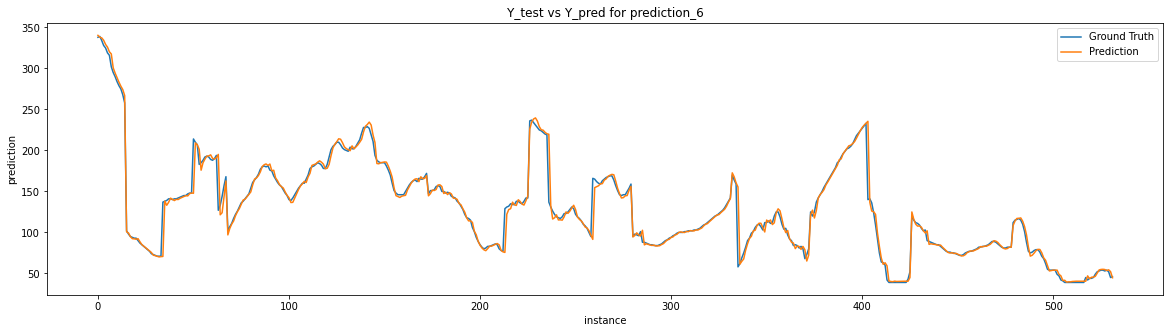

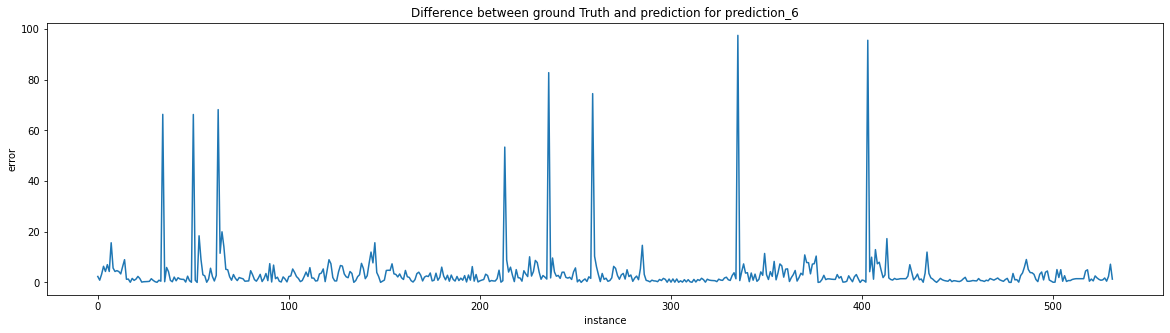

received a window size of  7


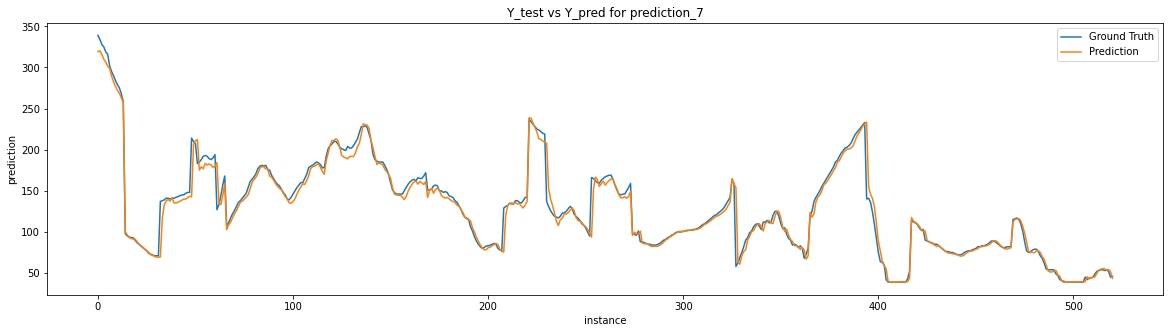

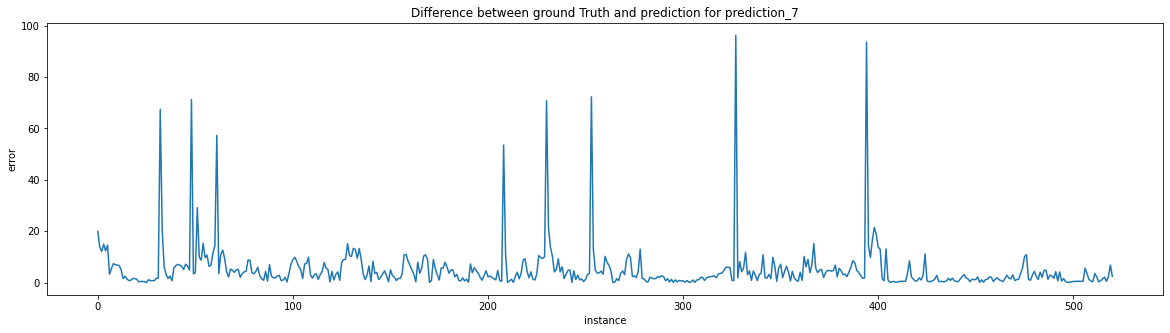

received a window size of  8


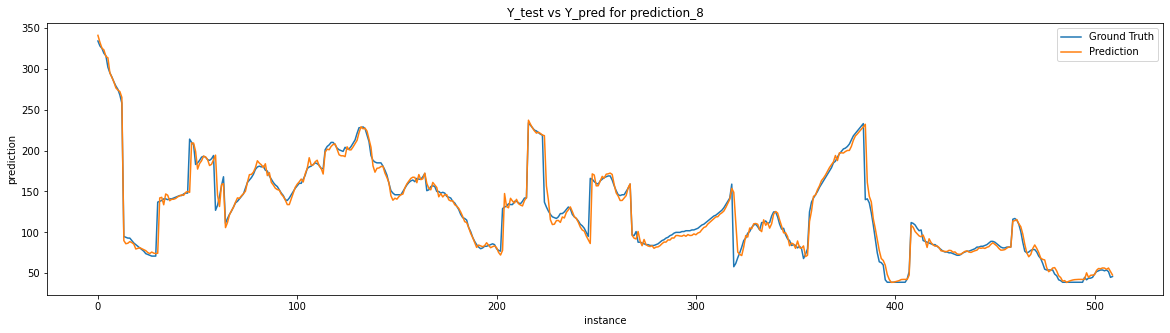

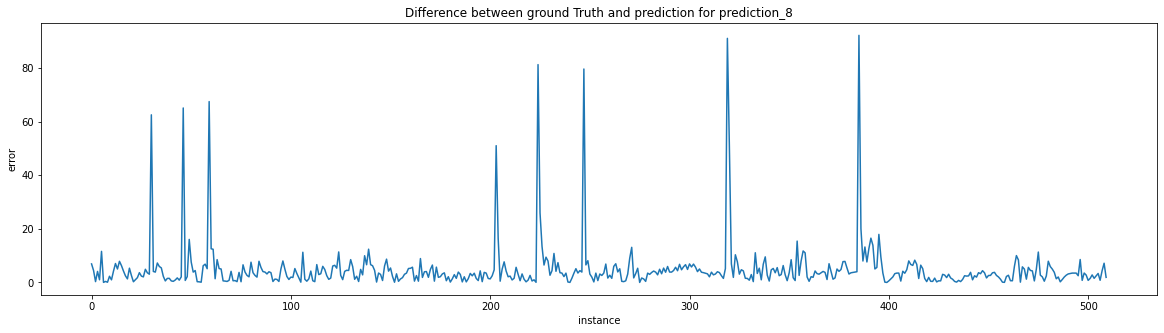

received a window size of  9


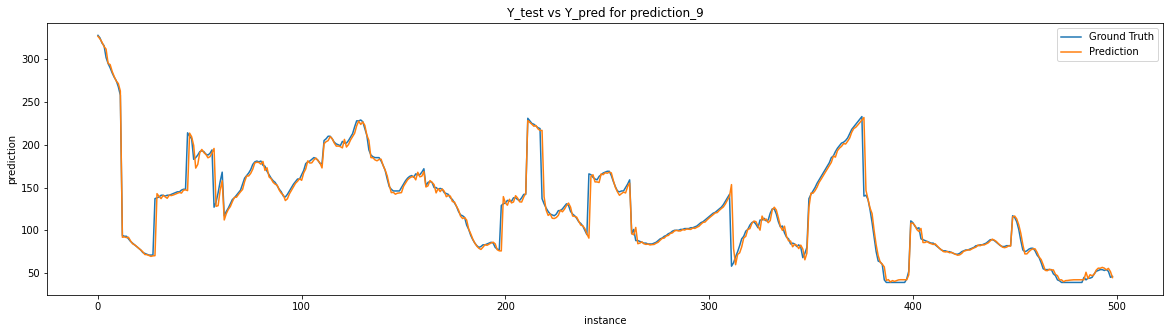

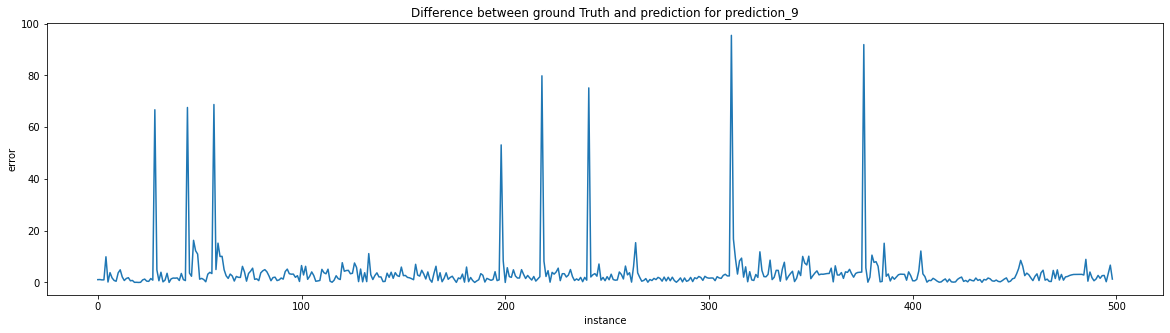

received a window size of  10


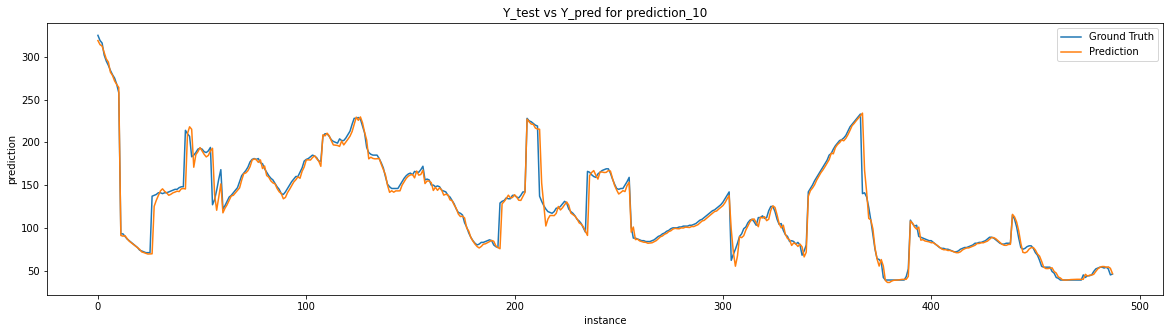

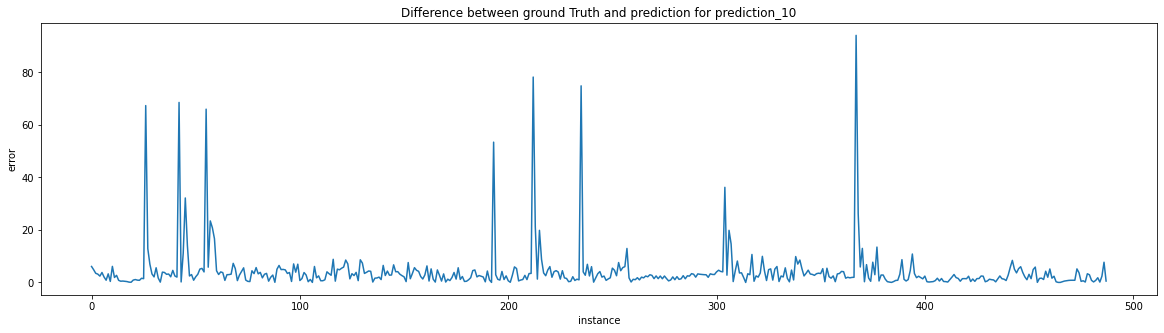

received a window size of  11


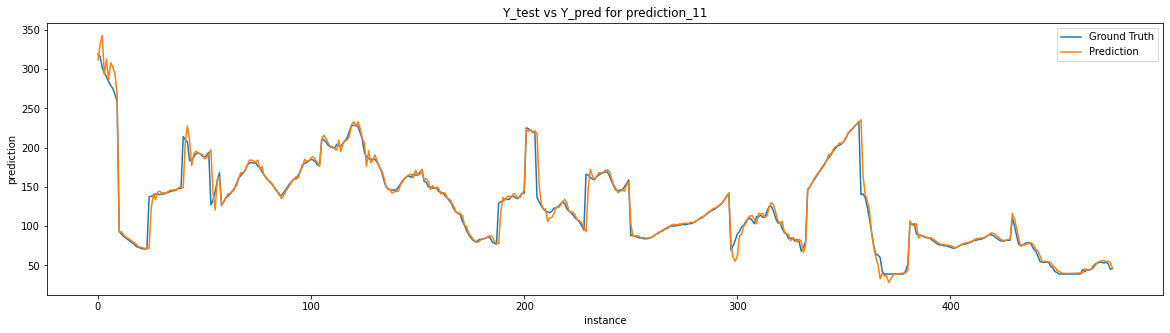

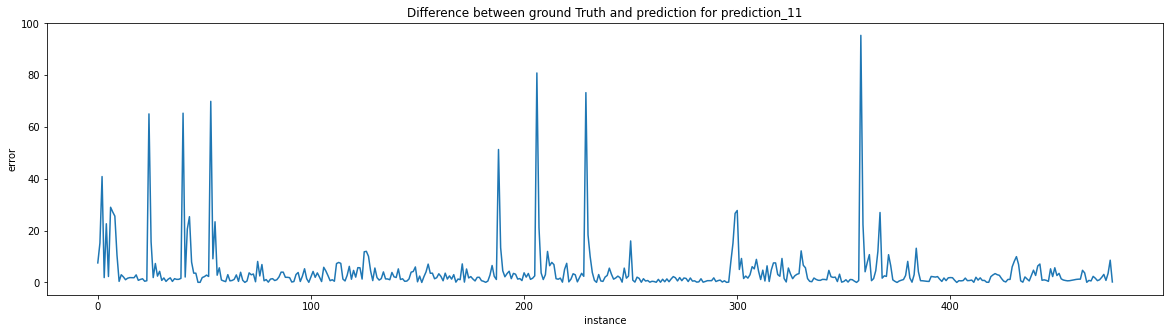

received a window size of  12


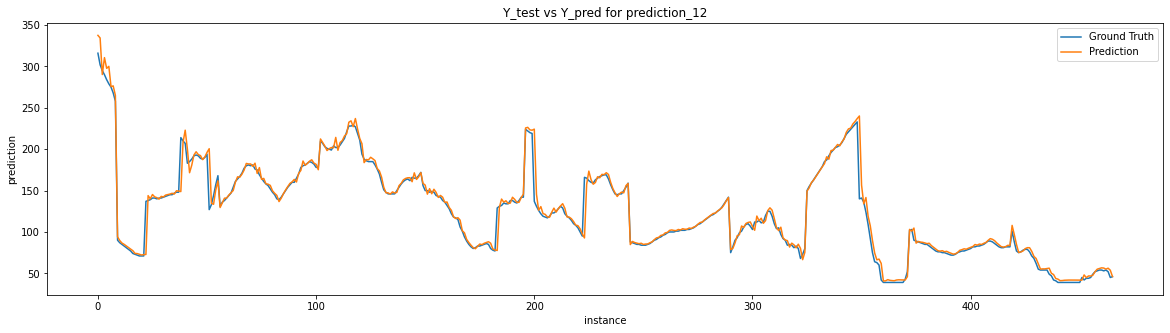

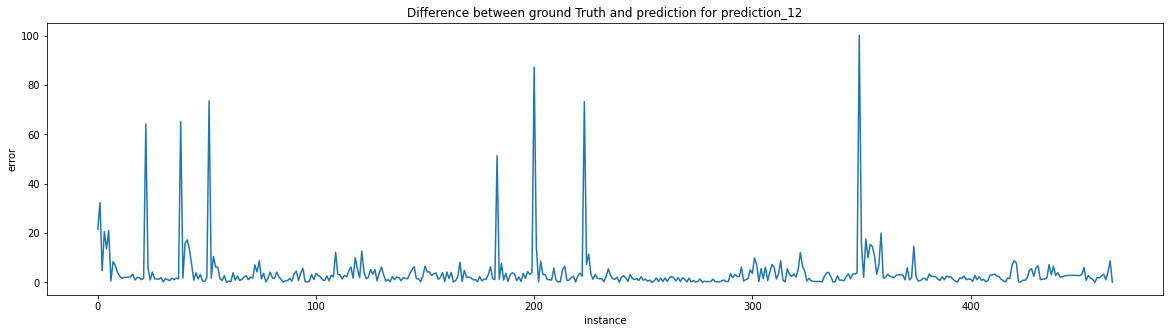

received a window size of  13


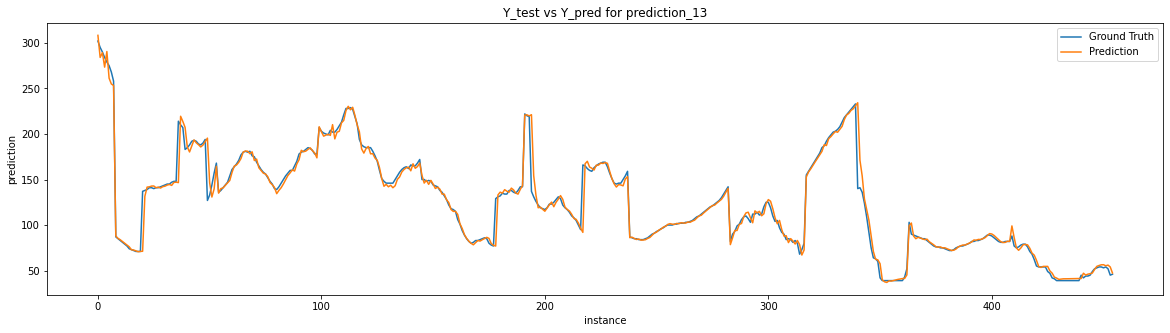

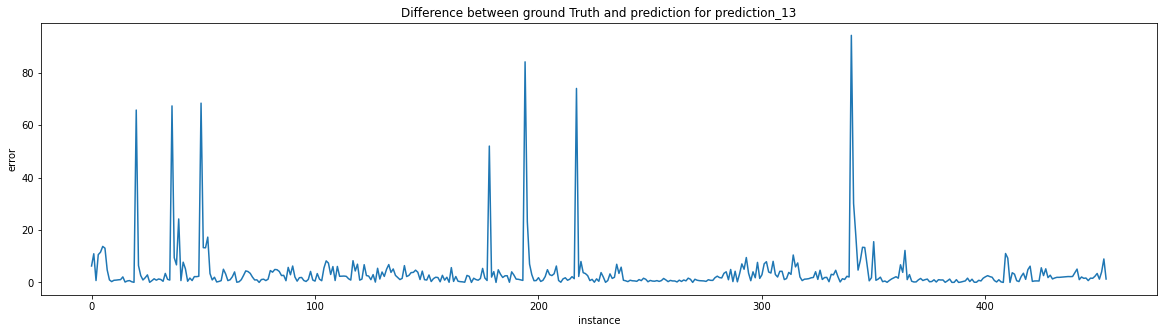

received a window size of  14


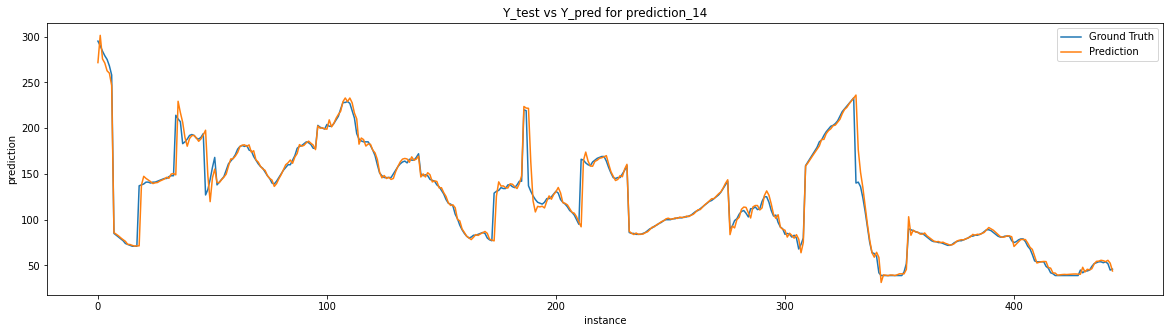

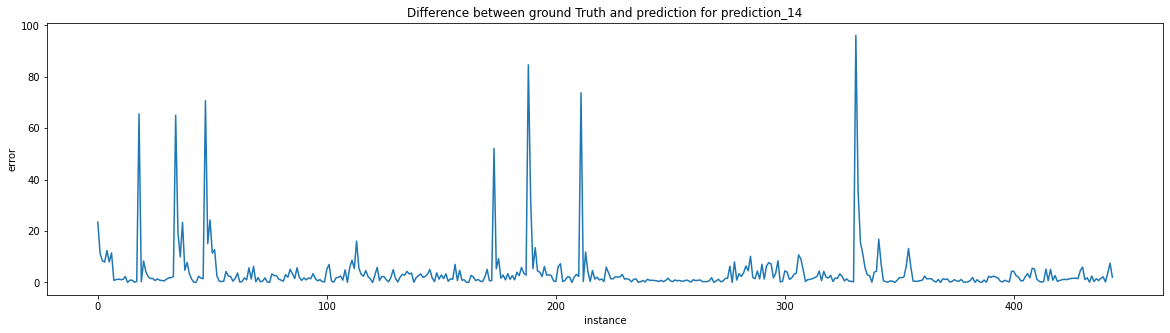

received a window size of  15


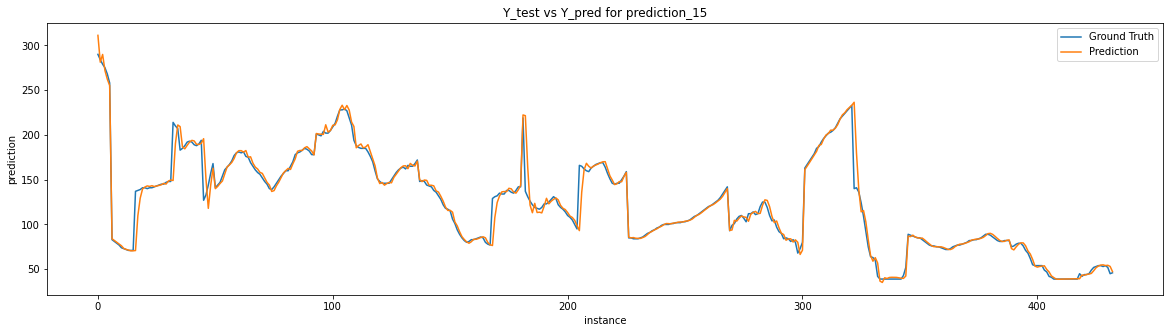

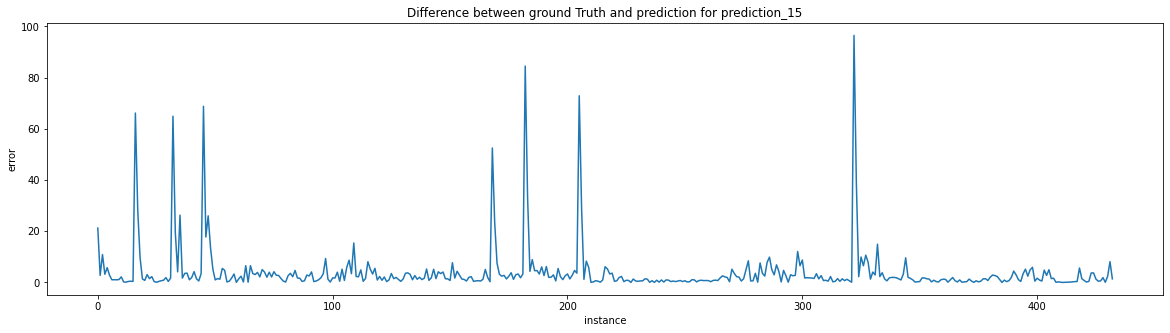

received a window size of  16


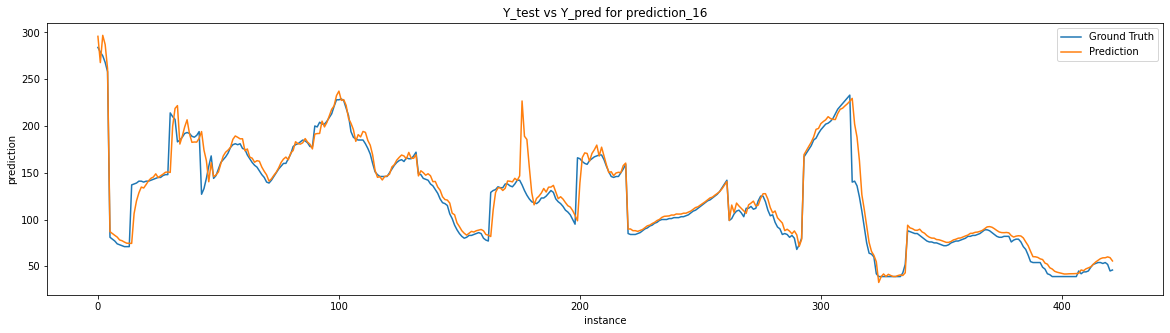

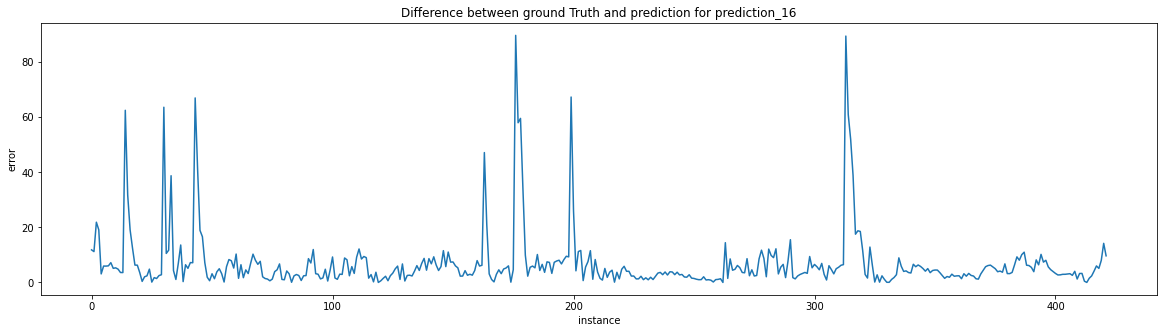

received a window size of  17


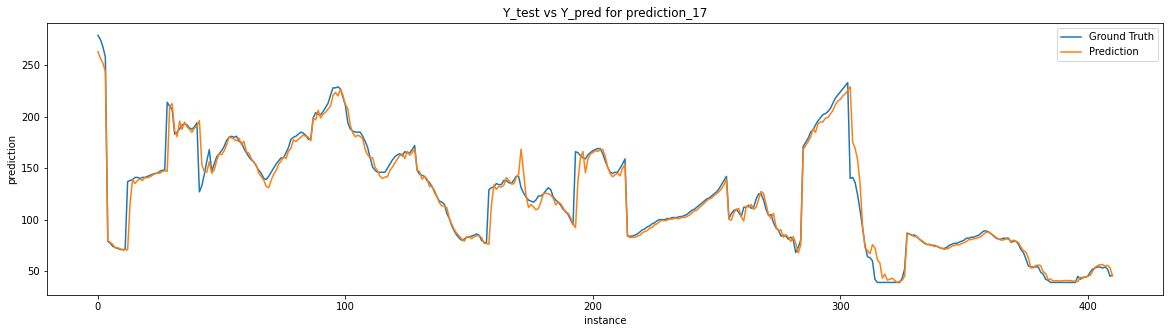

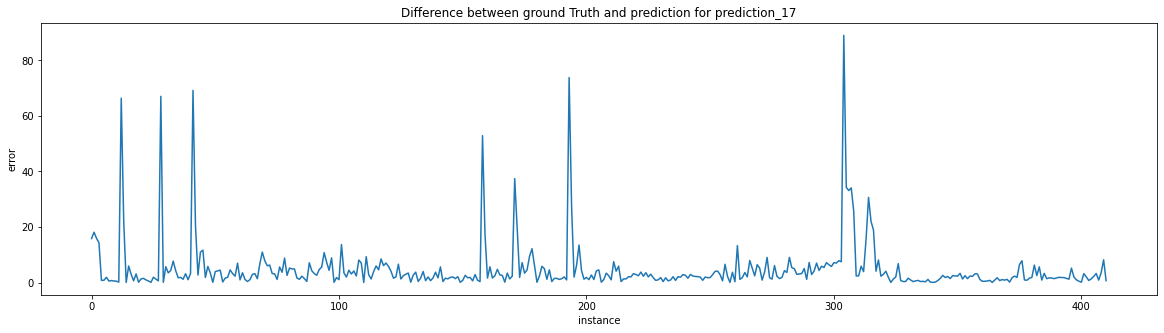

received a window size of  18


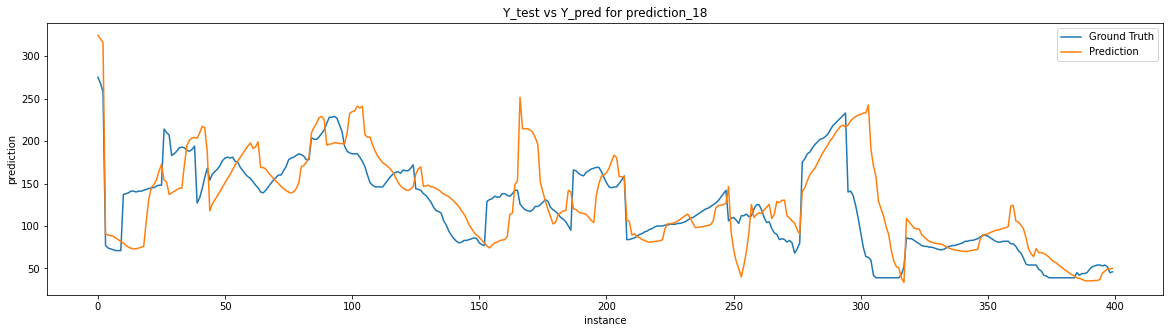

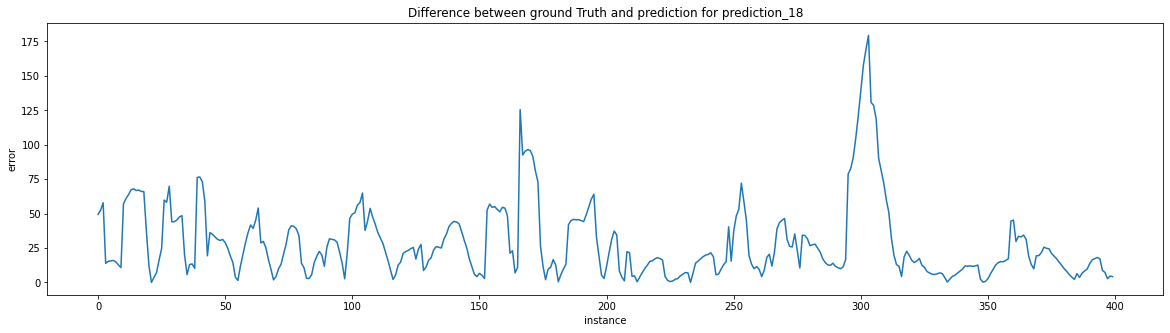

received a window size of  19


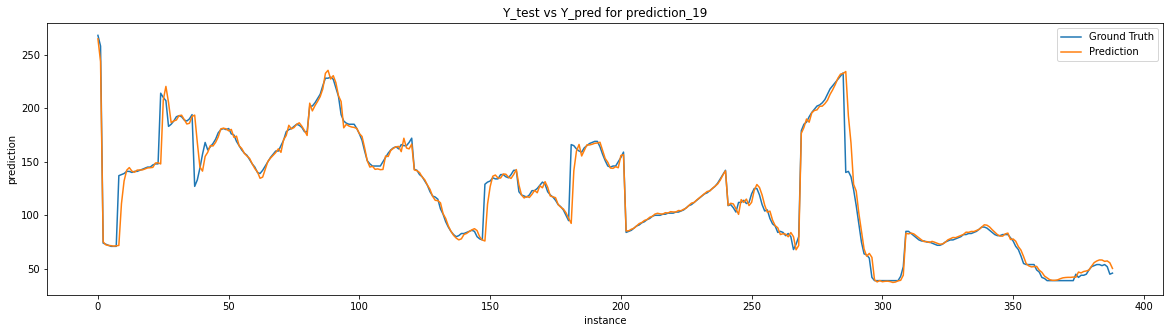

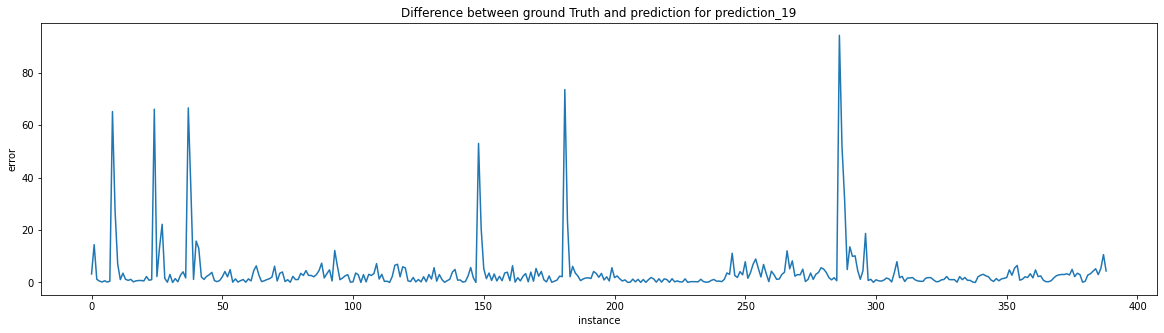

In [122]:
for keys in prediction_dictionary:
    X_train, Y_train, X_test, Y_test = generate_training_data(int(keys.split("_")[1]))
    
    #plotting the ground truth vs prediction for each instance
    plt.figure(figsize=(20,5))
    plt.plot(Y_test)
    plt.plot(prediction_dictionary[keys])
    plt.title('Y_test vs Y_pred for '+keys)
    plt.ylabel('prediction')
    plt.xlabel('instance')
    plt.legend(['Ground Truth', 'Prediction'], loc='upper right')
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(abs(prediction_dictionary[keys]-Y_test))
    plt.title('Difference between ground Truth and prediction for ' + keys)
    plt.ylabel('error')
    plt.xlabel('instance')
    plt.show()

In [125]:
optimal_dictionary={}
for keys in prediction_dictionary:
    X_train, Y_train, X_test, Y_test = generate_training_data(int(keys.split("_")[1])) #window size is different so we need to recompute train test data

    optimal_dictionary[keys] = sum(abs(prediction_dictionary[keys]-Y_test))/Y_test.shape[0]
print("the most accurate prediction is from " , min(optimal_dictionary , key=optimal_dictionary.get))
print("Hence our most optimal window size is ", min(optimal_dictionary , key=optimal_dictionary.get).split("_")[1])

received a window size of  3
received a window size of  4
received a window size of  5
received a window size of  6
received a window size of  7
received a window size of  8
received a window size of  9
received a window size of  10
received a window size of  11
received a window size of  12
received a window size of  13
received a window size of  14
received a window size of  15
received a window size of  16
received a window size of  17
received a window size of  18
received a window size of  19
the most accurate prediction is from  prediction_4
Hence our most optimal window size is  4


In [127]:
print(optimal_dictionary)


{'prediction_3': array([3.9047377]), 'prediction_4': array([3.69052107]), 'prediction_5': array([4.0229957]), 'prediction_6': array([3.71231981]), 'prediction_7': array([5.11533159]), 'prediction_8': array([4.98117748]), 'prediction_9': array([3.87418378]), 'prediction_10': array([4.25529777]), 'prediction_11': array([4.3070196]), 'prediction_12': array([4.13211604]), 'prediction_13': array([3.8102998]), 'prediction_14': array([3.93474026]), 'prediction_15': array([4.0243828]), 'prediction_16': array([6.88261737]), 'prediction_17': array([4.82898036]), 'prediction_18': array([28.37253474]), 'prediction_19': array([3.98194818])}
(389, 1)


Now what I did was basically train several models on datasets corresponding to different window_sizes ranging from 3 to 19 and stored their results. After which I plotted the results, and checked out the predictions of each model. It is important that the model trains well and also works well on real life data. Based on this, we can see that the window_size of 4 works the best. 

NOTE: This window_size is the best for my model architecture but might not be so great for models with different architectures. 

All the graphs for the experiment is in the cells above. 

TO further improve on this model, we can also try out different model architectures by adding more layers, tweaking the number of hidden units in the lstm, trying out different optimizers, batchsizes, loss functions etc. But for now, this model seems to perform really well on the data.